# Evolutionary algorithm

In [94]:
import os
import numpy as np
import scipy.spatial
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import cm
from pylab import rcParams
rcParams['figure.figsize'] = 14, 7

## Поиск максимума функции

Мы будем искать максимум функции $f(x)=-x(x-1)(x-2)(x-3)(x-4)$

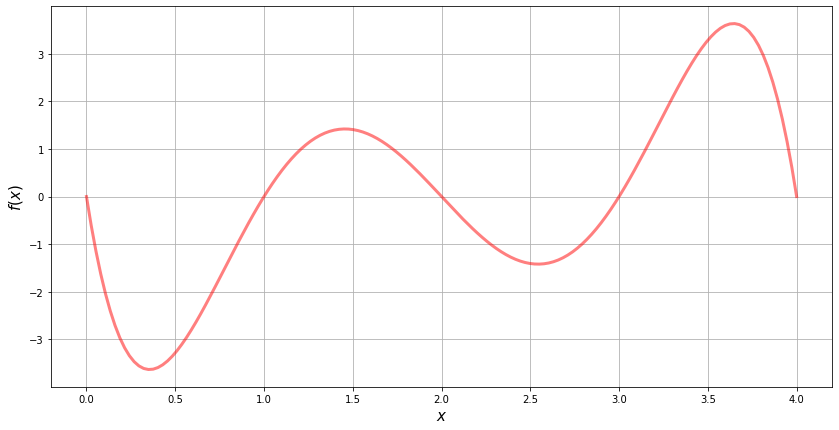

In [4]:
def func(x):
    return(-x * (x-1) * (x - 2) * (x - 3) * (x -4))

# Интервал, на котором мы будем работать с функцией
x_vals = np.linspace(0, 4, 150)
# Значение функции на данном интервале
Fx_vals = func(x_vals)

plt.plot(x_vals, Fx_vals, c = 'red', alpha = 0.5, linewidth = 3)
plt.grid()
plt.ylabel('$f(x)$', fontsize = 15)
plt.xlabel('$x$', fontsize = 15)
plt.show()

## Задача - нахождение глобального максимума представленной функции на интервале от 0 до 4

Для этого будет использоваться эволюционный алгоритм
Все действия будут выполняться на основе данной статьи: https://towardsdatascience.com/an-extensible-evolutionary-algorithm-example-in-python-7372c56a557b

Generate an initial population of individuals randomly.
Evaluate the fitness of each individual in the population.
Repeat as often as you like:

* Select individuals with a good fitness score for reproduction;
* Let them produce offsprings;
* Mutate these offsprings;
* Evaluate the fitness of each individual in the population;
* Let the individuals with a bad fitness score die.

Pick the individual with the highest fitness as the solution.

### 1. Генерация начальной популяции

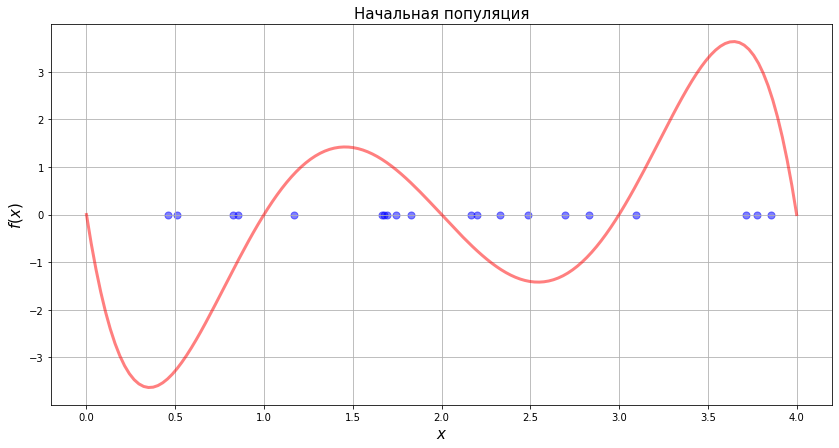

In [9]:
# Функция для генерации начальной популяции 
def initial_population(interval_min, interval_max, amount):
    return(np.random.uniform(interval_min, interval_max, size = amount))

# Генерируем начальную популяцию
init_pop = initial_population(0, 4, 20)

# Нарисуем расположение особей на графике
plt.plot(x_vals, Fx_vals, c = 'red', alpha = 0.5, linewidth = 3)
plt.scatter(init_pop, [0]*len(init_pop), c = 'blue', alpha = 0.5, s = 50)
plt.grid()
plt.ylabel('$f(x)$', fontsize = 15)
plt.xlabel('$x$', fontsize = 15)
plt.title('Начальная популяция', fontsize = 15)
plt.show()

### 2. Оценка функции приспособленности

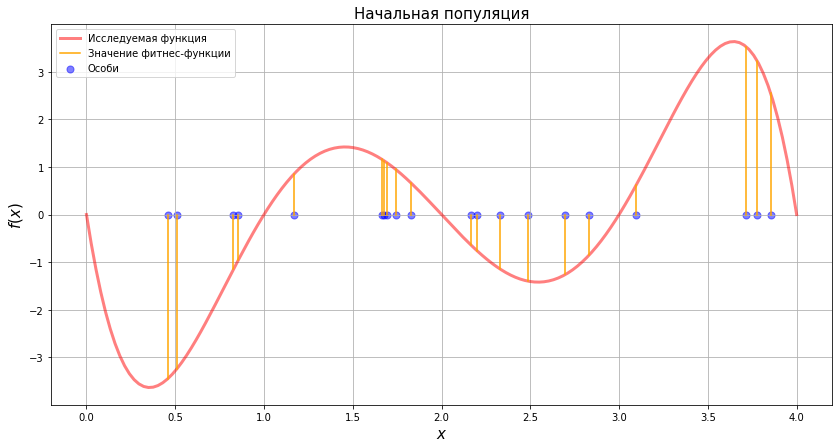

In [10]:
# Задаем функцию приспособленности
# В данном случае, это и есть значение функции в данной точке (так как мы ищем максимум функции)

def eval_fitness(arr_pop, function):
    # Рассчет значений функции во всех точках
    y_vals = function(arr_pop)
    return(y_vals)
    
fitness_score = eval_fitness(init_pop, func)

plt.plot(x_vals, Fx_vals, c = 'red', alpha = 0.5, linewidth = 3, label = 'Исследуемая функция')
plt.scatter(init_pop, [0]*len(init_pop), c = 'blue', alpha = 0.5, s = 50, label = 'Особи')
for i in range(0, len(fitness_score)):
    i_pop = init_pop[i]
    i_fitness_score = fitness_score[i]
    if i == len(fitness_score)-1:
        plt.plot([i_pop, i_pop], [0, i_fitness_score], c = 'orange', label = 'Значение фитнес-функции')
    else:
        plt.plot([i_pop, i_pop], [0, i_fitness_score], c = 'orange')
plt.grid()
plt.ylabel('$f(x)$', fontsize = 15)
plt.xlabel('$x$', fontsize = 15)
plt.legend()
plt.title('Начальная популяция', fontsize = 15)
plt.show()

### 3. Отбор наиболее приспособленных особей

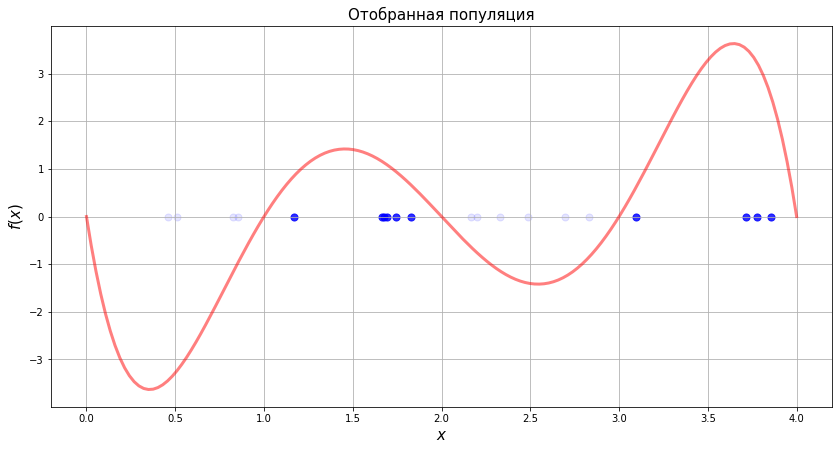

In [11]:
# В результате отбора оставляем только половину из 40 начальных особей
# arr_pop       --- особи
# fitness_score --- значение фитнес-функции для каждой особи
# n_fitted      --- количество наиболее приспособленных особей, которое требуется оставить в популяции
def selection(arr_pop, fitness_score, n_fitted):
    # Индексы n_fitted наиболее приспособленных особей
    id_selected = (-fitness_score).argsort()[:n_fitted]
    return(arr_pop[id_selected])
    
selected_individuals = selection(init_pop, fitness_score, 10)

# Нарисуем расположение особей на графике
plt.plot(x_vals, Fx_vals, c = 'red', alpha = 0.5, linewidth = 3)
plt.scatter(selected_individuals, [0]*len(selected_individuals), c = 'blue', alpha = 0.8, s = 50)
plt.scatter(init_pop, [0]*len(init_pop), c = 'blue', alpha = 0.1, s = 50)
plt.grid()
plt.ylabel('$f(x)$', fontsize = 15)
plt.xlabel('$x$', fontsize = 15)
plt.title('Отобранная популяция', fontsize = 15)
plt.show()

### 4. Скрещивание / размножение особей

### 5. Мутация (Этапы объединены)

Добавим операцию мутации для потомков, которые образовались в результате скрещивания

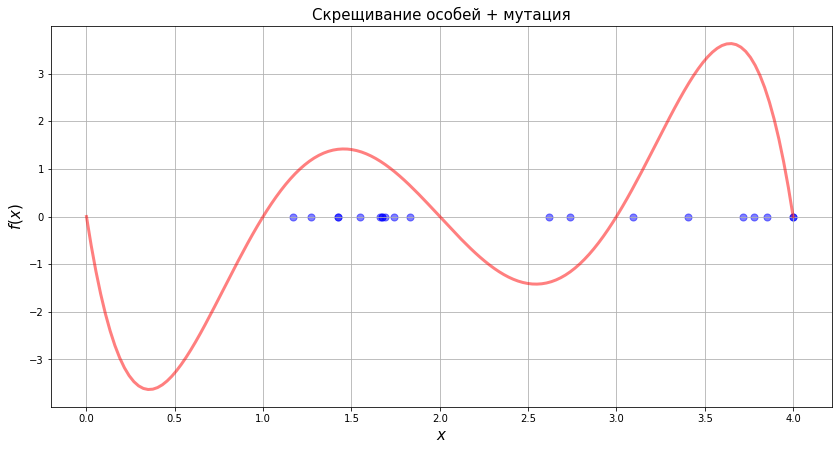

In [13]:
# Операция скрещивания: взятие среднего значения от одного из родителей
# Функция добавления потомков и их мутации
# interval_min         --- минимальная граница интервала 
# interval_max         --- максимальная граница интервала
# selected_individuals --- отобранные на предыдущем шаге наиболее приспособленные особи
# n_mut                --- количество особей из потомков, которые будут мутировать
def create_offspring(interval_min, interval_max, selected_individuals, n_mut):
    # Функция, которая изменяет генотип нескольких случайно выбранных особей
    def mutate(arr_pop):
        mutuation_ids  = np.arange(0,len(arr_pop))
        np.random.shuffle(mutuation_ids)
        # Первые n_mut особей будут мутировать
        mutuation_individuals = arr_pop[mutuation_ids[:n_mut]]
        # Генерация случайного значения 
        disturbance = np.random.uniform(-2, 2, size = n_mut)
        mutated = mutuation_individuals + disturbance 
        
        # Если мутировавший потомок выходит за границы оцениваемого интервала
        # То ему присваивается значение границы интервала
        mutated[mutated > interval_max] = interval_max
        mutated[mutated < interval_min] = interval_min
        # Заменяем исхожных потомков на мутировавших
        arr_pop[mutuation_ids[:n_mut]] = mutated 
        return(arr_pop)
        
    new_population = list(selected_individuals)
    
    # Определяется по n_mut потомков на каждой итерации
    for _ in [1,2]:
        # Список индексов
        ids = np.arange(0,len(selected_individuals))
        np.random.shuffle(ids)
        # Сопоставление особей, которые будут скрещены
        ids = ids.reshape(-1,2)

        # Операция скрещивания
        comparison = selected_individuals[ids]
        # Для каждой пары родителей берем их среднее значение
        offspring = comparison.mean(axis = 1)
        
        # Мутация 
        offspring = mutate(offspring)

        # Добавляем потомков в популяцию
        new_population.extend(offspring)
        
    new_population = np.array(new_population)
    return(new_population)

# Применение алгоритма
new_pop = create_offspring(0.0, 4.0, selected_individuals, 3)

plt.plot(x_vals, Fx_vals, c = 'red', alpha = 0.5, linewidth = 3)
plt.scatter(new_pop, [0]*len(new_pop), c = 'blue', alpha = 0.5, s = 50)
plt.grid()
plt.ylabel('$f(x)$', fontsize = 15)
plt.xlabel('$x$', fontsize = 15)
plt.title('Скрещивание особей + мутация', fontsize = 15)
plt.show()

#### Алгоритм поиска глобального максимума функции

In [16]:
# Функция для генерации начальной популяции 
def initial_population(interval_min, interval_max, amount):
    return(np.random.uniform(interval_min, interval_max, size = amount))

# Функция приспособленности
# В данном случае, это и есть значение функции в данной точке (так как мы ищем максимум функции)
def eval_fitness(arr_pop, function):
    # Рассчет значений функции во всех точках
    y_vals = function(arr_pop)
    return(y_vals)

# Функция отбора наиболее приспособленных особей
# arr_pop       --- особи
# fitness_score --- значение фитнес-функции для каждой особи
# n_fitted      --- количество наиболее приспособленных особей, которое требуется оставить
def selection(arr_pop, fitness_score, n_fitted):
    # Индексы n_fitted наиболее приспособленных особей
    id_selected = (-fitness_score).argsort()[:n_fitted]
    return(arr_pop[id_selected])

# Функция добавления потомков и их мутации
def create_offspring(interval_min, interval_max, selected_individuals, n_mut):
    # Функция, которая изменяет генотип нескольких случайно выбранных особей
    def mutate(arr_pop):
        mutuation_ids  = np.arange(0,len(arr_pop))
        np.random.shuffle(mutuation_ids)
        # Первые n_mut особей будут мутировать
        mutuation_individuals = arr_pop[mutuation_ids[:n_mut]]
        # Генерация случайного значения 
        disturbance = np.random.uniform(-2, 2, size = n_mut)
        mutated = mutuation_individuals + disturbance 
        
        # Если мутировавший потомок выходит за границы оцениваемого интервала
        # То ему присваивается значение границы интервала
        mutated[mutated > interval_max] = interval_max
        mutated[mutated < interval_min] = interval_min
        # Заменяем исхожных потомков на мутировавших
        arr_pop[mutuation_ids[:n_mut]] = mutated 
        return(arr_pop)
        
    new_population = list(selected_individuals)
    
    # Определяется по n_mut потомков на каждой итерации
    for _ in [1,2]:
        # Список индексов
        ids = np.arange(0,len(selected_individuals))
        np.random.shuffle(ids)
        # Сопоставление особей, которые будут скрещены
        ids = ids.reshape(-1,2)

        # Операция скрещивания
        comparison = selected_individuals[ids]
        # Для каждой пары родителей берем их среднее значение
        offspring = comparison.mean(axis = 1)
        
        # Мутация 
        offspring = mutate(offspring)

        # Добавляем потомков в популяцию
        new_population.extend(offspring)
        
    new_population = np.array(new_population)
    return(new_population)

# Функция - критерий остановки
def ostanova(selected_individuals):
    minimum = np.min(selected_individuals)
    maximum = np.max(selected_individuals)
    # Разброс величин в отобранной популяции
    R = maximum - minimum
    if R < 0.1:
        return(True)
    else:
        return(False)

###########################################
#  Алгоритм поиска глобального максимума  #
###########################################
# function     --- функция, которую необходимо исследоватьъ
# interval_min --- минимальная граница интервала 
# interval_max --- максимальная граница интервала
# amount       --- количество особей в начальной популяции
# n_fitted     --- количество наиболее приспособленных особей, которое требуется оставить после отбора (ЧЕТНОЕ ЧИСЛО)
# n_mut        --- количество особей, которые будут мутировать в каждом поколении
# iterations   --- количество итераций для поиска
def EA_search(function, interval_min, interval_max, amount, n_fitted, n_mut, iterations = 10):
    # Первый этап - инициализация начальной выборки 
    population = initial_population(interval_min, interval_max, amount)
    best_fitness_scores = []
    for iter_number in range(1, iterations + 1):

        # Оценка функции приспособленности
        population_fitness_score = eval_fitness(population, function)
        best_fitness_scores.append(np.max(population_fitness_score))
        # Отбор наиболее приспособленных
        selected_individuals = selection(population, population_fitness_score, n_fitted)
        
        # Интервал, на котором мы будем работать с функцией
        x_vals = np.linspace(0, 4, 150)
        # Значение функции на данном интервале
        Fx_vals = func(x_vals)
        plt.plot(x_vals, Fx_vals, c = 'red', alpha = 0.5, linewidth = 3)
        plt.scatter(selected_individuals, [0]*len(selected_individuals), c = 'blue', alpha = 0.5, s = 50, label = 'Отобранные особи')
        plt.scatter(population, [0]*len(population), c = 'blue', alpha = 0.1, s = 50)
        plt.grid()
        plt.ylabel('$f(x)$', fontsize = 15)
        plt.xlabel('$x$', fontsize = 15)
        name = 'Поколение ' + str(iter_number)
        plt.title(name, fontsize = 15)
        plt.legend(loc = 'upper left')
        plt.xlim(-0.5, 4.5)
        plt.show()
        
        # Если выполняется критерий остановки, то алгоритм прекращает работу
        if ostanova(selected_individuals) == True:
            break
        # Если это последнее поколение, то потомства оно не дает
        if iter_number == iterations:
            pass
        else:
            # Самые приспособленные дают потомство (в котором возможны мутации)
            population = create_offspring(interval_min, interval_max, selected_individuals, n_mut)
        
    # По достижению заданного количества поколений - проивзодится выбор наиболее оптимального решения
    id_max = np.argmax(population_fitness_score)
    print('Максимум расположен в точке ', population[id_max])
    print('Значение функции в данной точке ', population_fitness_score[id_max])

    plt.plot(best_fitness_scores)
    plt.grid()
    plt.ylabel('Fitness', fontsize = 15)
    plt.xlabel('Generation', fontsize = 15)
    plt.show()

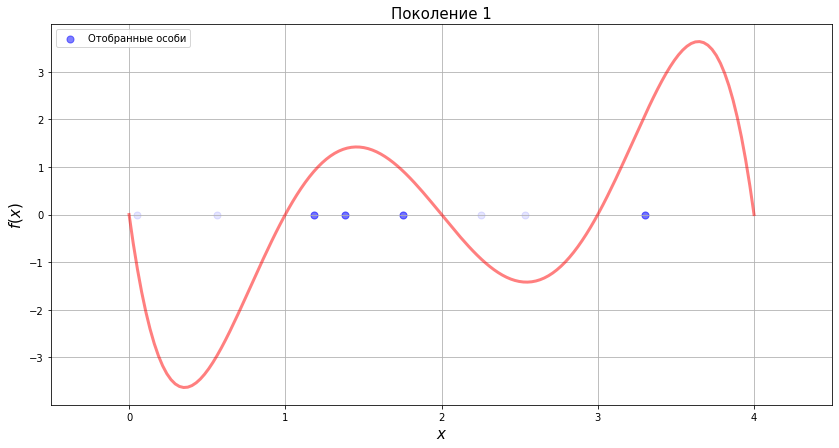

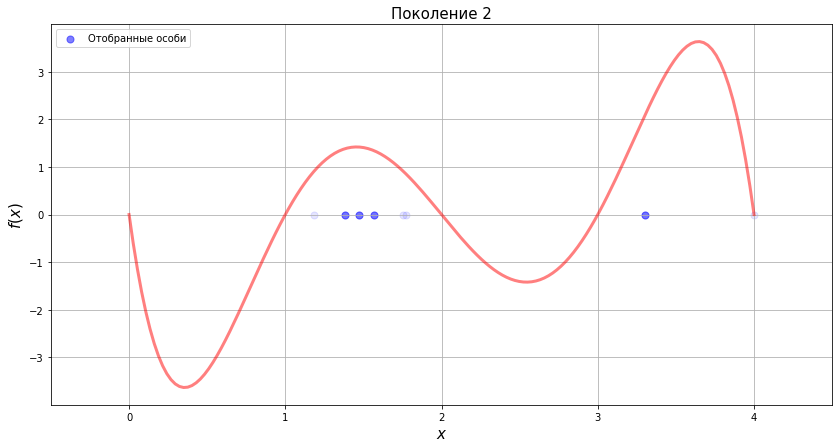

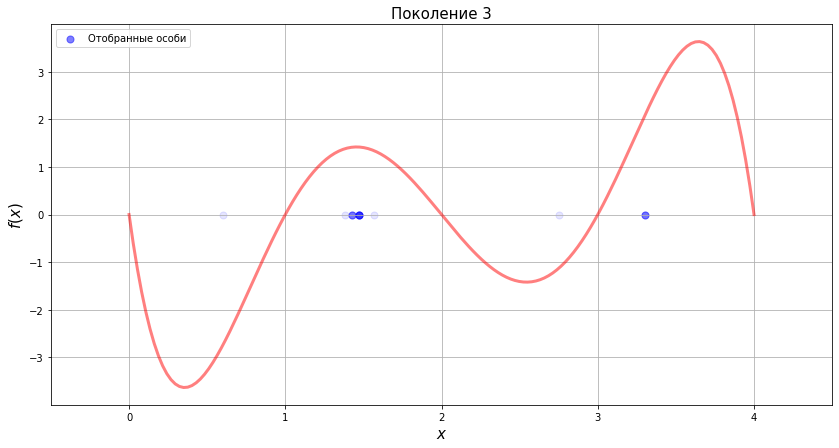

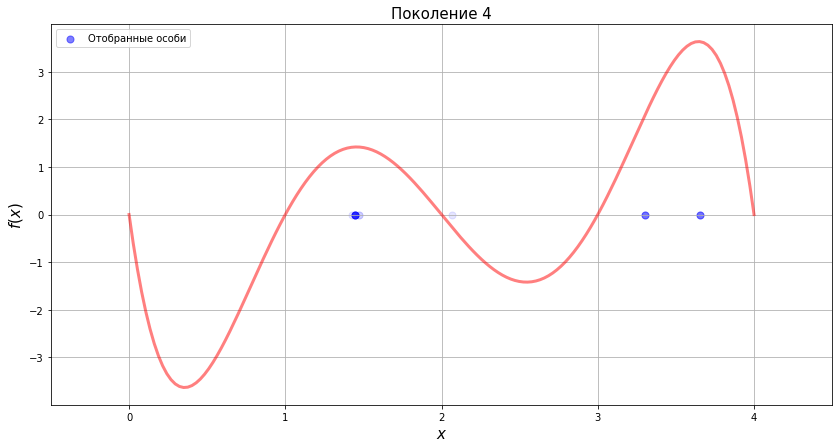

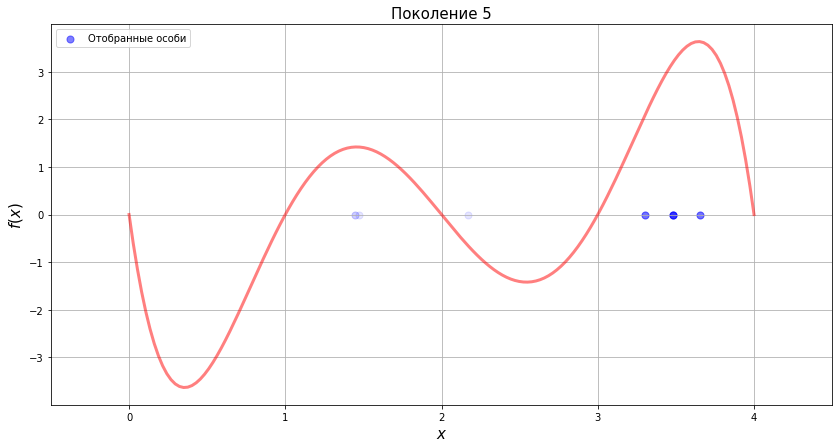

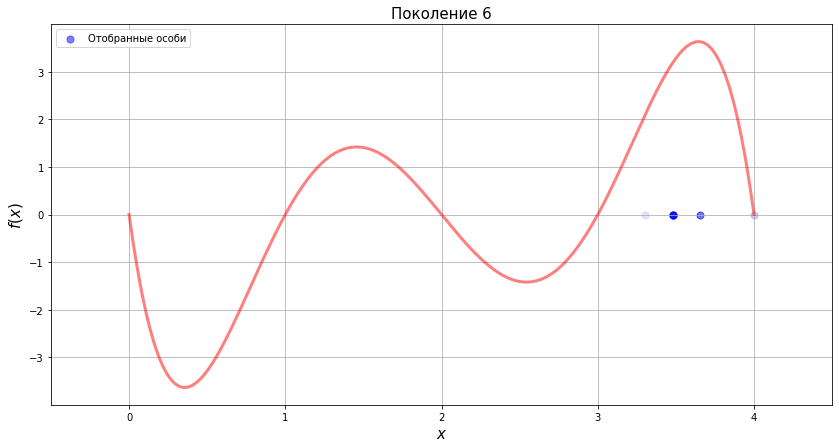

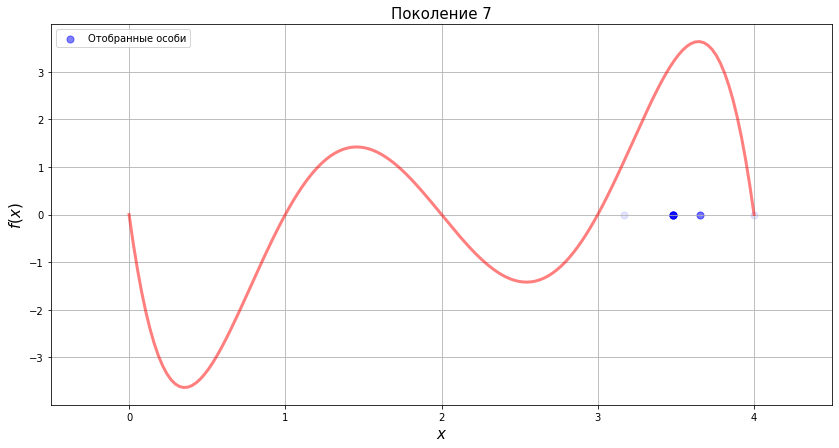

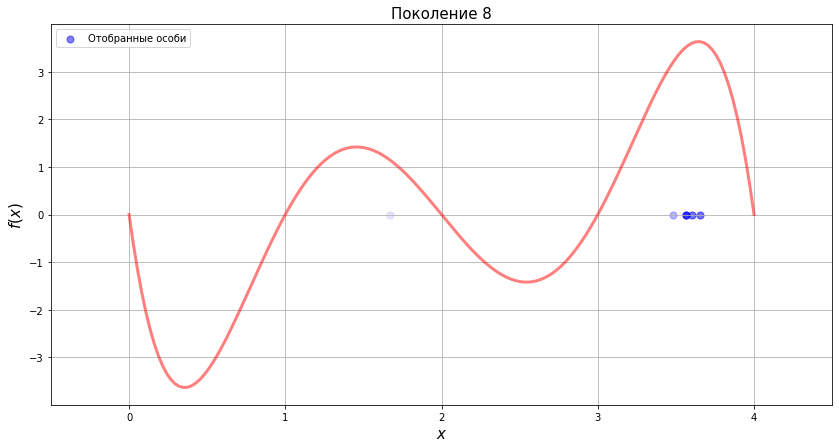

Максимум расположен в точке  3.6528564935160976
Значение функции в данной точке  3.6300139214358054


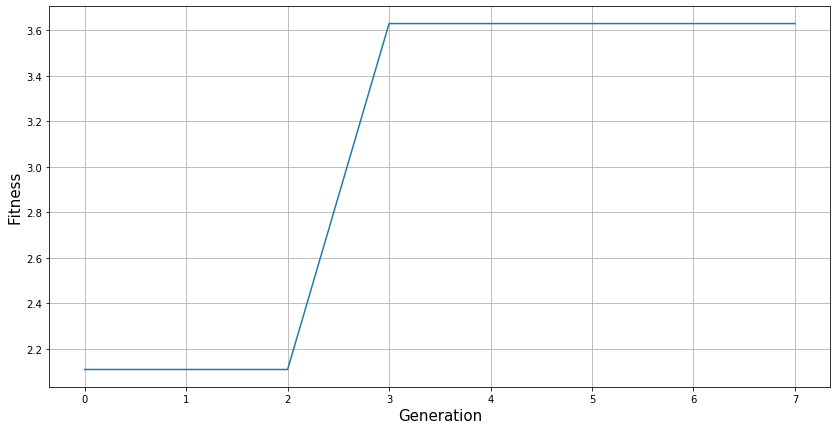

In [20]:
EA_search(function = func, interval_min = 0, interval_max = 4, amount = 8, n_fitted = 4, n_mut = 1, iterations = 10)

Демонстрация работы алгоритма с начальной популяцией в 40 особей представлена ниже

![EA_animation_1.gif](https://raw.githubusercontent.com/Dreamlone/ITMO_Masters_degree/master/Images/animation_1.gif)

## Задача коммивояжера

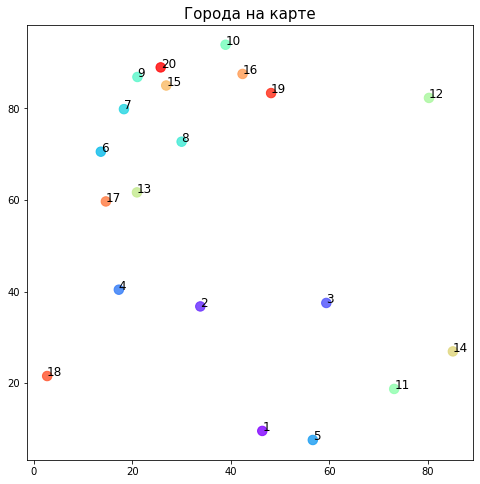

,X,Y,codes
0,46.379994,9.561289,1
1,33.802526,36.757682,2


In [48]:
rcParams['figure.figsize'] = 8, 8
# Функция-генератор городов и их расположение на карте
# n_cities --- количество генерируемых городов
# minimum  --- координата нижнего левого угла
# maximum  --- координата верхнего правого угла
def cities_generator(n_cities, minimum, maximum):
    cities = np.random.uniform(minimum, maximum, size = (n_cities,2))
    codes = np.arange(1, len(cities)+1)
    dataframe = pd.DataFrame(cities, columns = ['X', 'Y'])
    dataframe['codes'] = codes
    return(dataframe)

dataframe = cities_generator(20, 0, 100)
plt.scatter(dataframe['X'], dataframe['Y'], c = codes, cmap = 'rainbow', alpha = 0.8, s = 90)
for i in range(len(dataframe)):
    x = dataframe['X'][i]
    y = dataframe['Y'][i]
    code = dataframe['codes'][i]
    plt.text(x, y , code, fontsize = 12)
plt.title('Города на карте', fontsize = 15)
plt.show()

dataframe.head(2)

Потенциальные решения в данной задаче - последовательность городов

In [165]:
# Функция для генерации начальной популяции 
# dataframe --- датафрейм с координатами и городами
# amount    --- количество особей в начальной популяции
def initial_population(dataframe, amount):
    n_cities = len(dataframe)
    cities_names  = np.arange(1, n_cities + 1)
    cities_names = np.tile(cities_names, amount)
    cities_names = cities_names.reshape(amount, -1)
    # Перемешиваем вдоль нужных осей 
    list(map(np.random.shuffle, cities_names))
    return(cities_names)

# Функция приспособленности
# В данном случае - общяя протяженность маршрута
# arr_pop   --- популяция
# dataframe --- датафрейм с координатами
def eval_fitness(arr_pop, dataframe):
    
    def euclidean_dist(arr_1, arr_2):
        vector = np.sqrt((arr_1[:,0] - arr_2[:,0])**2 + (arr_1[:,1] - arr_2[:,1])**2)
        return(vector)
    
    scores = []
    for individual in arr_pop:
        individual = pd.DataFrame(individual, columns = ['codes'])
        data = pd.merge(individual, dataframe, on = 'codes')
        
        # Перемещение первого города в конец списка        
        r_points_first = np.array(data[1:][['X', 'Y']])
        r_points_last = np.array(data[:1][['X', 'Y']])
        r_points = np.vstack((r_points_first, r_points_last))
        
        # По евклидовой метрике оцениваем пройденное расстояние
        distances = euclidean_dist(np.array(data[['X', 'Y']]), r_points)
        scores.append(np.sum(distances))
    return(np.array(scores))

# Функция отбора наиболее приспособленных особей - у которых наиболее низкое значение длины маршрута
# arr_pop       --- особи
# fitness_score --- значение фитнес-функции для каждой особи
# n_fitted      --- количество наиболее приспособленных особей, которое требуется оставить
def selection(arr_pop, fitness_score, n_fitted):
    # Индексы n_fitted наиболее приспособленных особей
    id_selected = (-fitness_score).argsort()[-n_fitted:]
    return(arr_pop[id_selected])

# Функция добавления потомков и их мутации
def create_offspring(selected_individuals, n_mut):
    
    # Функция меняет местами у некоторых потомков паттерны из городов
    def mutate(arr_pop, n_mut):
        return(arr_pop)
        
    new_population = selected_individuals
    return(new_population)

first_population = initial_population(dataframe, 20)
scores = eval_fitness(first_population, dataframe)
selected_individuals = selection(first_population, scores, 10)
